In [1]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [2]:
# Importing the dataset
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')


In [4]:
movies.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Preparing the training set and the test set
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

In [5]:
# Getting the number of users and movies
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))

In [6]:
def convert(data):
    new_data = []
    for id_users in range(1, nb_users + 1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data
training_set = convert(training_set)
test_set = convert(test_set)

# Converting the data into Torch tensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

In [7]:
# Creating the architecture of the Neural Network
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

epoch: 1 loss: tensor(1.7721)
epoch: 2 loss: tensor(1.0966)
epoch: 3 loss: tensor(1.0534)
epoch: 4 loss: tensor(1.0382)
epoch: 5 loss: tensor(1.0308)
epoch: 6 loss: tensor(1.0266)
epoch: 7 loss: tensor(1.0237)
epoch: 8 loss: tensor(1.0219)
epoch: 9 loss: tensor(1.0207)
epoch: 10 loss: tensor(1.0195)
epoch: 11 loss: tensor(1.0188)
epoch: 12 loss: tensor(1.0187)
epoch: 13 loss: tensor(1.0178)
epoch: 14 loss: tensor(1.0173)
epoch: 15 loss: tensor(1.0172)
epoch: 16 loss: tensor(1.0170)
epoch: 17 loss: tensor(1.0167)
epoch: 18 loss: tensor(1.0166)
epoch: 19 loss: tensor(1.0164)
epoch: 20 loss: tensor(1.0161)
epoch: 21 loss: tensor(1.0160)
epoch: 22 loss: tensor(1.0159)
epoch: 23 loss: tensor(1.0157)
epoch: 24 loss: tensor(1.0158)
epoch: 25 loss: tensor(1.0159)
epoch: 26 loss: tensor(1.0156)
epoch: 27 loss: tensor(1.0154)
epoch: 28 loss: tensor(1.0150)
epoch: 29 loss: tensor(1.0131)
epoch: 30 loss: tensor(1.0112)
epoch: 31 loss: tensor(1.0091)
epoch: 32 loss: tensor(1.0091)
epoch: 33 loss: t

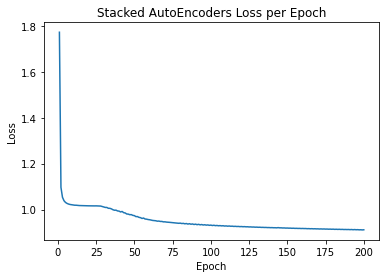

In [8]:
loss_list=[];
epoch_index=[];
nb_epoch = 200
for epoch in range(1, nb_epoch + 1):

    train_loss = 0
    s = 0.
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data*mean_corrector)
            s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))
    epoch_index.append(epoch);
    loss_list.append(train_loss/s)

plt.plot(epoch_index,loss_list)
plt.title("Stacked AutoEncoders Loss per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.close()


In [9]:
test_loss = 0
s = 0.
for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0)
    target = Variable(test_set[id_user]).unsqueeze(0)
    if torch.sum(target.data > 0) > 0:
        output = sae(input)
        target.require_grad = False
        output[target == 0] = 0
        loss = criterion(output, target)
        mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.data*mean_corrector)
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.9456)
